In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report, roc_auc_score, roc_curve)

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
def plot_distribution(data, columns, target_col='target', figsize=(8, 4)):
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            # Histograma por clase
            for target_val in data[target_col].unique():
                subset = data[data[target_col] == target_val]
                axes[i].hist(subset[col], alpha=0.7, label=f'Clase {target_val}', bins=20)
            
            axes[i].set_title(f'Distribución de {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frecuencia')
            axes[i].legend()
    
    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(data, figsize=(8, 4)):
    
    corr_matrix = data.corr()
    
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Generar heatmap
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='RdYlBu_r',
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    
    plt.title('Matriz de Correlación de Variables', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

def plot_outliers(data, columns, target_col='target', figsize=(8, 4)):
    n_cols = len(columns)
    n_rows = (n_cols + 2) // 3
    
    fig, axes = plt.subplots(n_rows, 3, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, col in enumerate(columns):
        if i < len(axes):
            sns.boxplot(data=data, x=target_col, y=col, ax=axes[i])
            axes[i].set_title(f'Boxplot de {col}')
    
    # Ocultar ejes vacíos
    for i in range(len(columns), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_class_balance(y, title="Distribución de Clases"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    # Gráfico de barras
    value_counts = y.value_counts()
    ax1.bar(value_counts.index, value_counts.values, color='skyblue')
    ax1.set_title(f'{title} - Conteo')
    ax1.set_xlabel('Clase')
    ax1.set_ylabel('Cantidad')
    
    for i, v in enumerate(value_counts.values):
        ax1.text(i, v + 5, str(v), ha='center', va='bottom')
    
    # Gráfico de pastel
    ax2.pie(value_counts.values, labels=[f'Clase {i}' for i in value_counts.index], 
            autopct='%1.1f%%', colors=sns.color_palette("pastel"))
    ax2.set_title(f'{title} - Porcentaje')
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, y_pred, model_name):
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred)
    }
    
    return results

def plot_confusion_matrices(models_results, y_test, figsize=(15, 12)):

    n_models = len(models_results)
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes
    
    for i, (model_name, results) in enumerate(models_results.items()):
        if i < len(axes):
            y_pred = results['predictions']
            cm = confusion_matrix(y_test, y_pred)
            
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'Matriz de Confusión - {model_name}')
            axes[i].set_xlabel('Predicción')
            axes[i].set_ylabel('Real')
    
    # Ocultar ejes vacíos
    for i in range(len(models_results), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(models_results, y_test, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    
    for model_name, results in models_results.items():
        y_pred_proba = results.get('probabilities')
        if y_pred_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curvas ROC - Comparación de Modelos')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [3]:

# 3. CARGA Y EXPLORACIÓN INICIAL DE DATOS

# Cargar datos
data = pd.DataFrame(load_breast_cancer().data, columns=load_breast_cancer().feature_names)
data['target'] = load_breast_cancer().target

print(f"\n📊 INFORMACIÓN GENERAL DEL DATASET:")
print(f"   • Forma del dataset: {data.shape}")
print(f"   • Número de variables: {data.shape[1] - 1}")
print(f"   • Número de observaciones: {data.shape[0]}")

print(f"\n📋 PRIMERAS 5 FILAS:")
print(data.head())

print(f"\n🔍 TIPOS DE DATOS:")
print(data.dtypes.value_counts())

print(f"\n📈 INFORMACIÓN DETALLADA:")
data.info()

print(f"\n❌ DATOS FALTANTES:")
missing_data = data.isnull().sum()
print(f"   • Total de valores faltantes: {missing_data.sum()}")
if missing_data.sum() > 0:
    print(missing_data[missing_data > 0])
else:
    print("   • No hay valores faltantes en el dataset ✅")

print(f"\n📊 ESTADÍSTICAS DESCRIPTIVAS:")
print(data.describe())



📊 INFORMACIÓN GENERAL DEL DATASET:
   • Forma del dataset: (569, 31)
   • Número de variables: 30
   • Número de observaciones: 569

📋 PRIMERAS 5 FILAS:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.


🎯 ANÁLISIS DE LA VARIABLE OBJETIVO:
   • Clase 0 (Maligno): 212 (37.3%)
   • Clase 1 (Benigno): 357 (62.7%)


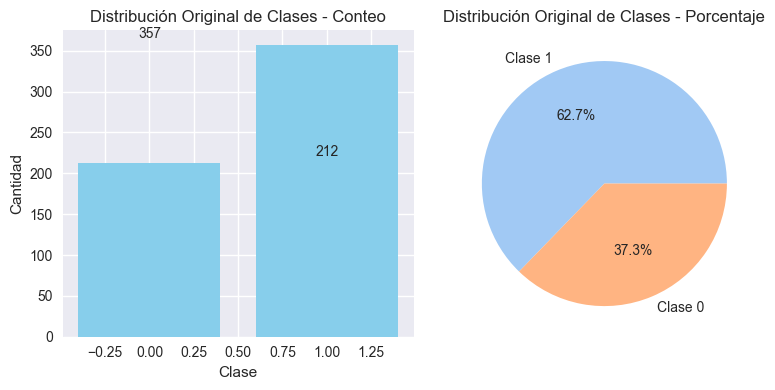

In [4]:

# 4. ANÁLISIS DE LA VARIABLE OBJETIVO

print(f"\n🎯 ANÁLISIS DE LA VARIABLE OBJETIVO:")
target_distribution = data['target'].value_counts()
print(f"   • Clase 0 (Maligno): {target_distribution[0]} ({target_distribution[0]/len(data)*100:.1f}%)")
print(f"   • Clase 1 (Benigno): {target_distribution[1]} ({target_distribution[1]/len(data)*100:.1f}%)")

plot_class_balance(data['target'], "Distribución Original de Clases")




📈 ANÁLISIS DE DISTRIBUCIONES:


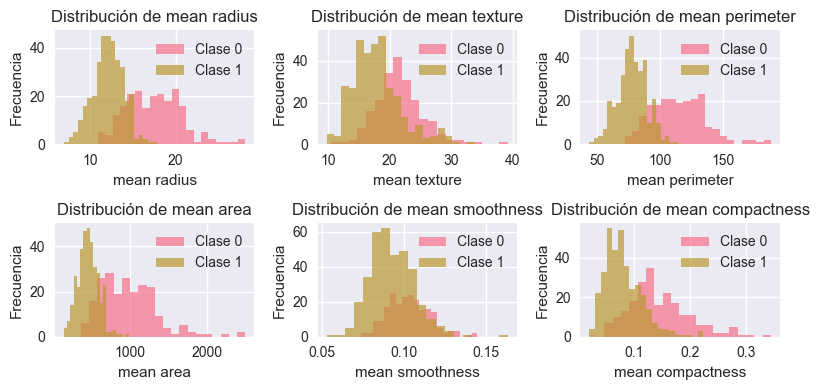

In [5]:
# 5. ANÁLISIS DE DISTRIBUCIONES

print(f"\n📈 ANÁLISIS DE DISTRIBUCIONES:")

# Seleccionar columnas principales para análisis
main_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 
                'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points']

# Generar gráficos de distribución
plot_distribution(data, main_features[:6])


🔗 ANÁLISIS DE CORRELACIONES:


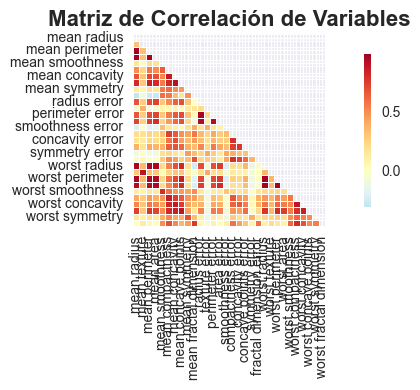


🎯 CORRELACIONES MÁS ALTAS CON LA VARIABLE OBJETIVO:
    1. worst concave points     : 0.794
    2. worst perimeter          : 0.783
    3. mean concave points      : 0.777
    4. worst radius             : 0.776
    5. mean perimeter           : 0.743
    6. worst area               : 0.734
    7. mean radius              : 0.730
    8. mean area                : 0.709
    9. mean concavity           : 0.696
   10. worst concavity          : 0.660


In [6]:
# 6. ANÁLISIS DE CORRELACIONES
# ============================

print(f"\n🔗 ANÁLISIS DE CORRELACIONES:")

# Matriz de correlación
corr_matrix = plot_correlation_matrix(data.drop('target', axis=1))

# Correlaciones más altas con la variable objetivo
target_correlations = data.corr()['target'].abs().sort_values(ascending=False)
print(f"\n🎯 CORRELACIONES MÁS ALTAS CON LA VARIABLE OBJETIVO:")
for i, (feature, corr) in enumerate(target_correlations[1:11].items()):
    print(f"   {i+1:2d}. {feature:<25}: {corr:.3f}")



⚠️  ANÁLISIS DE OUTLIERS:


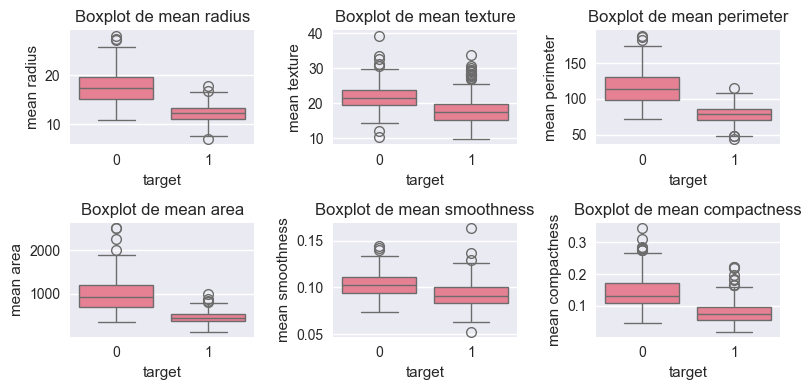


📊 CONTEO DE OUTLIERS POR VARIABLE (método IQR):
   • mean radius              :  14 outliers
   • mean texture             :   7 outliers
   • mean perimeter           :  13 outliers
   • mean area                :  25 outliers
   • mean smoothness          :   6 outliers
   • mean compactness         :  16 outliers
   • mean concavity           :  18 outliers
   • mean concave points      :  10 outliers


In [7]:

# 7. DETECCIÓN DE OUTLIERS
# ========================

print(f"\n⚠️  ANÁLISIS DE OUTLIERS:")

# Generar boxplots para las características principales
plot_outliers(data, main_features[:6])

# Detectar outliers usando IQR
def detect_outliers_iqr(df, columns):
    outliers_count = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count[col] = len(outliers)
    return outliers_count

outliers_info = detect_outliers_iqr(data, main_features)
print(f"\n📊 CONTEO DE OUTLIERS POR VARIABLE (método IQR):")
for feature, count in outliers_info.items():
    print(f"   • {feature:<25}: {count:3d} outliers")



In [8]:
# 8. PREPARACIÓN DE DATOS
# =======================

print(f"\n🔧 PREPARACIÓN DE DATOS:")

# Separar características y variable objetivo
X = data.drop('target', axis=1)
y = data['target']

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"   • Tamaño conjunto entrenamiento: {X_train.shape}")
print(f"   • Tamaño conjunto prueba: {X_test.shape}")

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   • Características escaladas ✅")




🔧 PREPARACIÓN DE DATOS:
   • Tamaño conjunto entrenamiento: (426, 30)
   • Tamaño conjunto prueba: (143, 30)
   • Características escaladas ✅



⚖️  BALANCEADO DE DATOS:
   • Ratio de balance: 0.596
   • Aplicando SMOTE + Tomek Links...
   • Datos balanceados:
     - Antes: {1: 267, 0: 159}
     - Después: {0: 266, 1: 266}


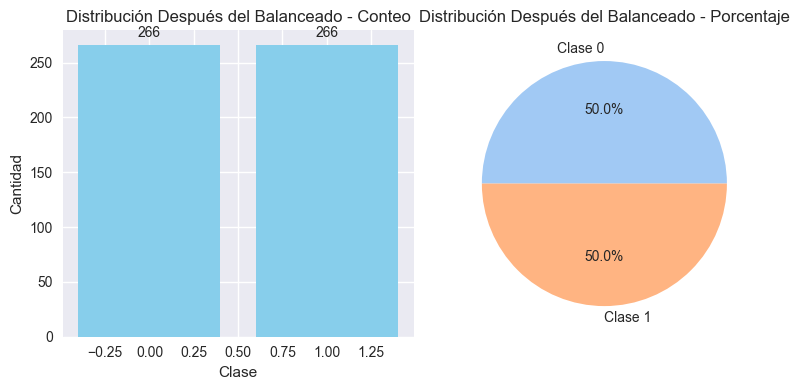

In [9]:
# 9. BALANCEADO DE DATOS (OPCIONAL)
# =================================

print(f"\n⚖️  BALANCEADO DE DATOS:")

# Verificar si es necesario balancear
class_counts = y_train.value_counts()
balance_ratio = min(class_counts) / max(class_counts)
print(f"   • Ratio de balance: {balance_ratio:.3f}")

if balance_ratio < 0.8:  # Si el desbalance es significativo
    print(f"   • Aplicando SMOTE + Tomek Links...")
    
    # Aplicar SMOTE + Tomek Links
    smote_tomek = SMOTETomek(random_state=42)
    X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train_scaled, y_train)
    
    print(f"   • Datos balanceados:")
    print(f"     - Antes: {y_train.value_counts().to_dict()}")
    print(f"     - Después: {pd.Series(y_train_balanced).value_counts().to_dict()}")
    
    # Visualizar el balanceado
    plot_class_balance(pd.Series(y_train_balanced), "Distribución Después del Balanceado")
    
    # Usar datos balanceados
    X_train_final = X_train_balanced
    y_train_final = y_train_balanced
else:
    print(f"   • No es necesario balancear los datos")
    X_train_final = X_train_scaled
    y_train_final = y_train



In [10]:
# 10. ENTRENAMIENTO DE MODELOS
# ============================

print(f"\n🤖 ENTRENAMIENTO DE MODELOS:")
print("=" * 40)

models_results = {}

# 1. Support Vector Machine
print("🔹 Entrenando SVM...")
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_final, y_train_final)
svm_pred = svm_model.predict(X_test_scaled)
svm_proba = svm_model.predict_proba(X_test_scaled)[:, 1]
models_results['SVM'] = {
    'model': svm_model,
    'predictions': svm_pred,
    'probabilities': svm_proba
}

# 2. Decision Tree
print("🔹 Entrenando Decision Tree...")
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train_final, y_train_final)
dt_pred = dt_model.predict(X_test_scaled)
dt_proba = dt_model.predict_proba(X_test_scaled)[:, 1]
models_results['Decision Tree'] = {
    'model': dt_model,
    'predictions': dt_pred,
    'probabilities': dt_proba
}

# 3. Random Forest
print("🔹 Entrenando Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train_final)
rf_pred = rf_model.predict(X_test_scaled)
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
models_results['Random Forest'] = {
    'model': rf_model,
    'predictions': rf_pred,
    'probabilities': rf_proba
}

# 4. Logistic Regression
print("🔹 Entrenando Logistic Regression...")
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_final, y_train_final)
lr_pred = lr_model.predict(X_test_scaled)
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
models_results['Logistic Regression'] = {
    'model': lr_model,
    'predictions': lr_pred,
    'probabilities': lr_proba
}

# 5. K-Nearest Neighbors
print("🔹 Entrenando K-Nearest Neighbors...")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_final, y_train_final)
knn_pred = knn_model.predict(X_test_scaled)
knn_proba = knn_model.predict_proba(X_test_scaled)[:, 1]
models_results['KNN'] = {
    'model': knn_model,
    'predictions': knn_pred,
    'probabilities': knn_proba
}



🤖 ENTRENAMIENTO DE MODELOS:
🔹 Entrenando SVM...
🔹 Entrenando Decision Tree...
🔹 Entrenando Random Forest...
🔹 Entrenando Logistic Regression...
🔹 Entrenando K-Nearest Neighbors...


In [11]:
# 11. EVALUACIÓN DE MODELOS
# =========================

print(f"\n📊 EVALUACIÓN DE MODELOS:")
print("=" * 50)

# Calcular métricas para todos los modelos
evaluation_results = []

for model_name, results in models_results.items():
    metrics = evaluate_model(
        results['model'], 
        X_test_scaled, 
        y_test, 
        results['predictions'], 
        model_name
    )
    evaluation_results.append(metrics)
    
    print(f"\n🔸 {model_name}:")
    print(f"   • Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"   • Precision: {metrics['Precision']:.4f}")
    print(f"   • Recall:    {metrics['Recall']:.4f}")
    print(f"   • F1-Score:  {metrics['F1-Score']:.4f}")
    print(f"   • ROC-AUC:   {metrics['ROC-AUC']:.4f}")

# Crear DataFrame con resultados
results_df = pd.DataFrame(evaluation_results)
results_df = results_df.set_index('Model')
results_df = results_df.round(4)

print(f"\n📋 TABLA COMPARATIVA DE RESULTADOS:")
print("=" * 60)
print(results_df)

# Identificar el mejor modelo por métrica
print(f"\n🏆 MEJORES MODELOS POR MÉTRICA:")
for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_model = results_df[metric].idxmax()
    best_score = results_df[metric].max()
    print(f"   • {metric:<10}: {best_model} ({best_score:.4f})")




📊 EVALUACIÓN DE MODELOS:

🔸 SVM:
   • Accuracy:  0.9720
   • Precision: 0.9886
   • Recall:    0.9667
   • F1-Score:  0.9775
   • ROC-AUC:   0.9739

🔸 Decision Tree:
   • Accuracy:  0.9301
   • Precision: 0.9651
   • Recall:    0.9222
   • F1-Score:  0.9432
   • ROC-AUC:   0.9328

🔸 Random Forest:
   • Accuracy:  0.9650
   • Precision: 0.9775
   • Recall:    0.9667
   • F1-Score:  0.9721
   • ROC-AUC:   0.9645

🔸 Logistic Regression:
   • Accuracy:  0.9650
   • Precision: 0.9885
   • Recall:    0.9556
   • F1-Score:  0.9718
   • ROC-AUC:   0.9683

🔸 KNN:
   • Accuracy:  0.9650
   • Precision: 0.9775
   • Recall:    0.9667
   • F1-Score:  0.9721
   • ROC-AUC:   0.9645

📋 TABLA COMPARATIVA DE RESULTADOS:
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                              
SVM                    0.9720     0.9886  0.9667    0.9775   0.9739
Decision Tree          0.9301     0.9651  0.9222    0.9432   0.9328
Random Forest  


📈 GENERANDO VISUALIZACIONES:


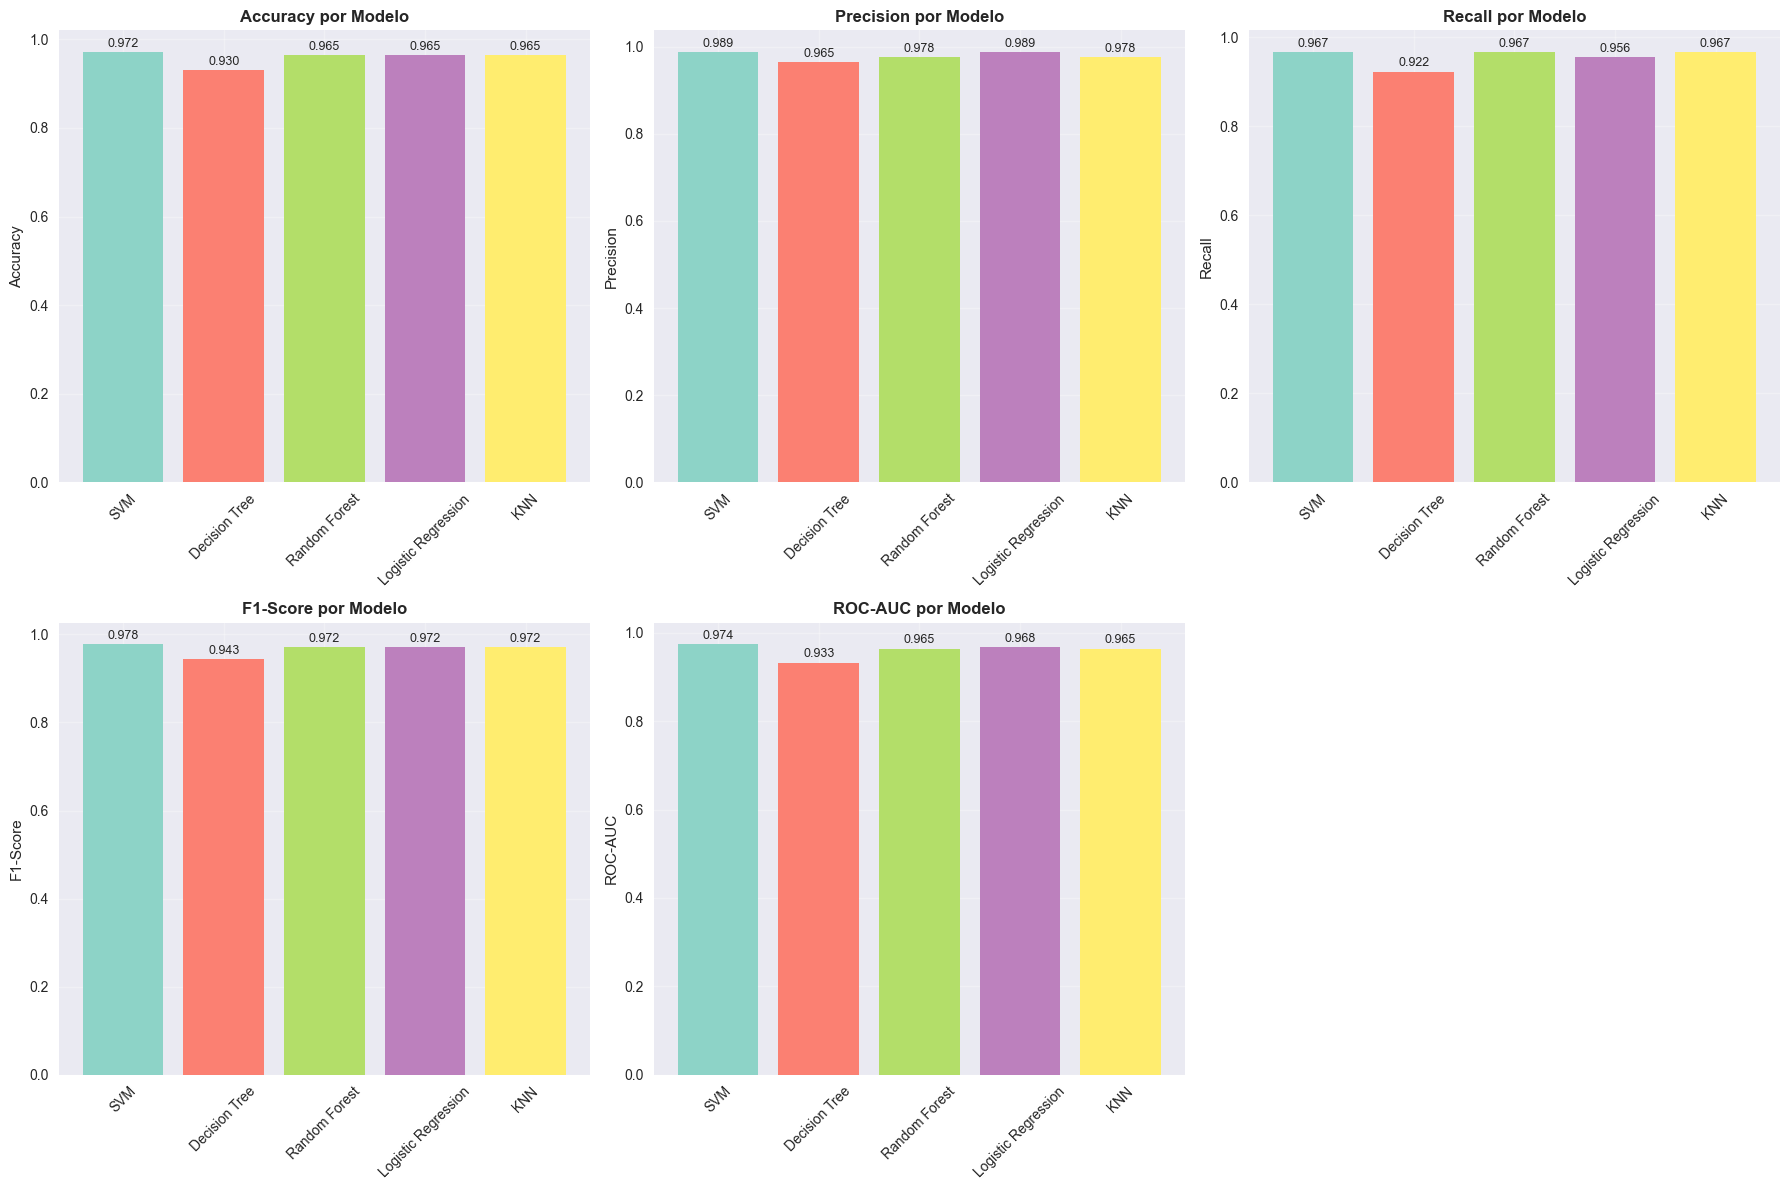

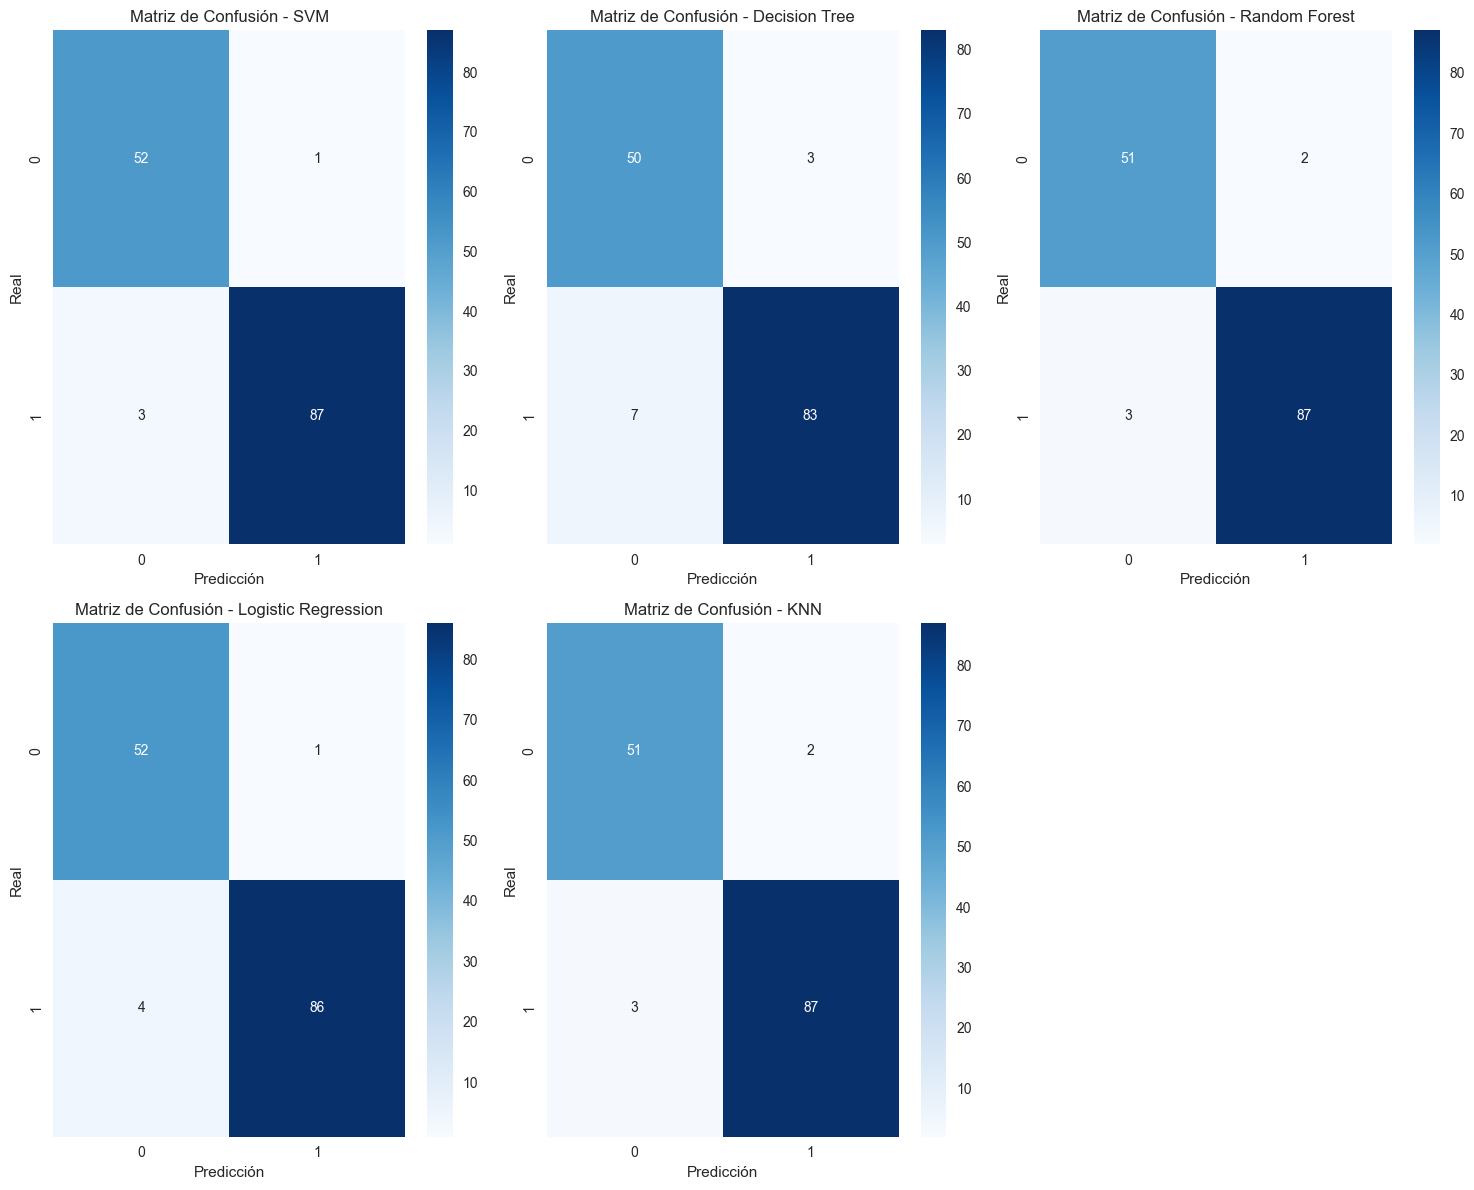

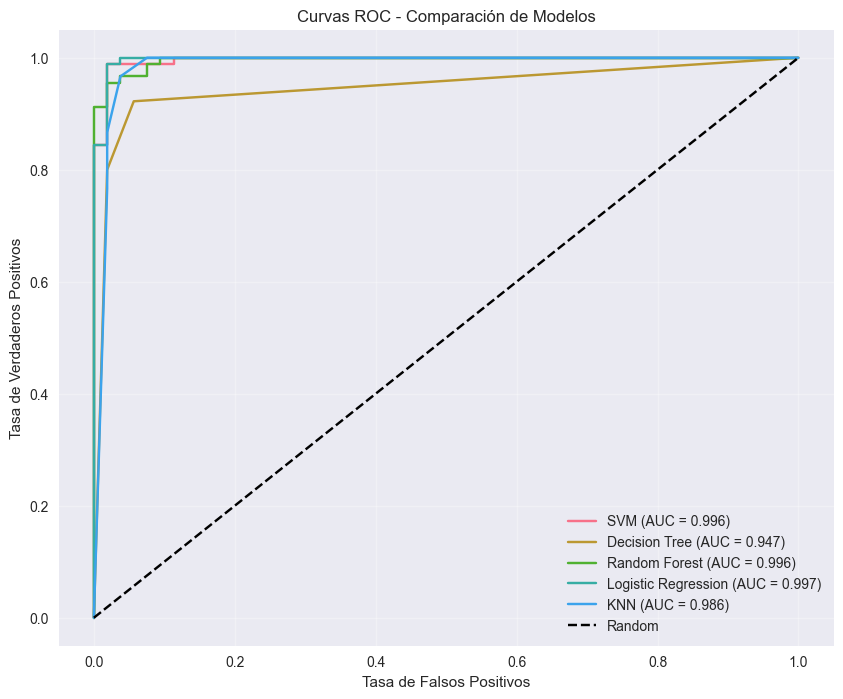

In [12]:
# 12. VISUALIZACIÓN DE RESULTADOS
# ===============================

print(f"\n📈 GENERANDO VISUALIZACIONES:")

# Gráfico de barras comparativo
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = plt.cm.Set3(np.linspace(0, 1, len(results_df)))

for i, metric in enumerate(metrics):
    if i < len(axes):
        bars = axes[i].bar(results_df.index, results_df[metric], color=colors)
        axes[i].set_title(f'{metric} por Modelo', fontweight='bold')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)
        
        # Agregar valores en las barras
        for bar, value in zip(bars, results_df[metric]):
            axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                        f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# Ocultar el último subplot si es necesario
if len(metrics) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Matrices de confusión
plot_confusion_matrices(models_results, y_test)

# Curvas ROC
plot_roc_curves(models_results, y_test)




🔍 ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS:

🌳 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES (Random Forest):
    1. worst area               : 0.1582
    2. worst concave points     : 0.1228
    3. worst radius             : 0.0944
    4. worst perimeter          : 0.0908
    5. mean concave points      : 0.0846
    6. mean perimeter           : 0.0632
    7. mean concavity           : 0.0588
    8. mean radius              : 0.0491
    9. worst concavity          : 0.0385
   10. mean area                : 0.0363


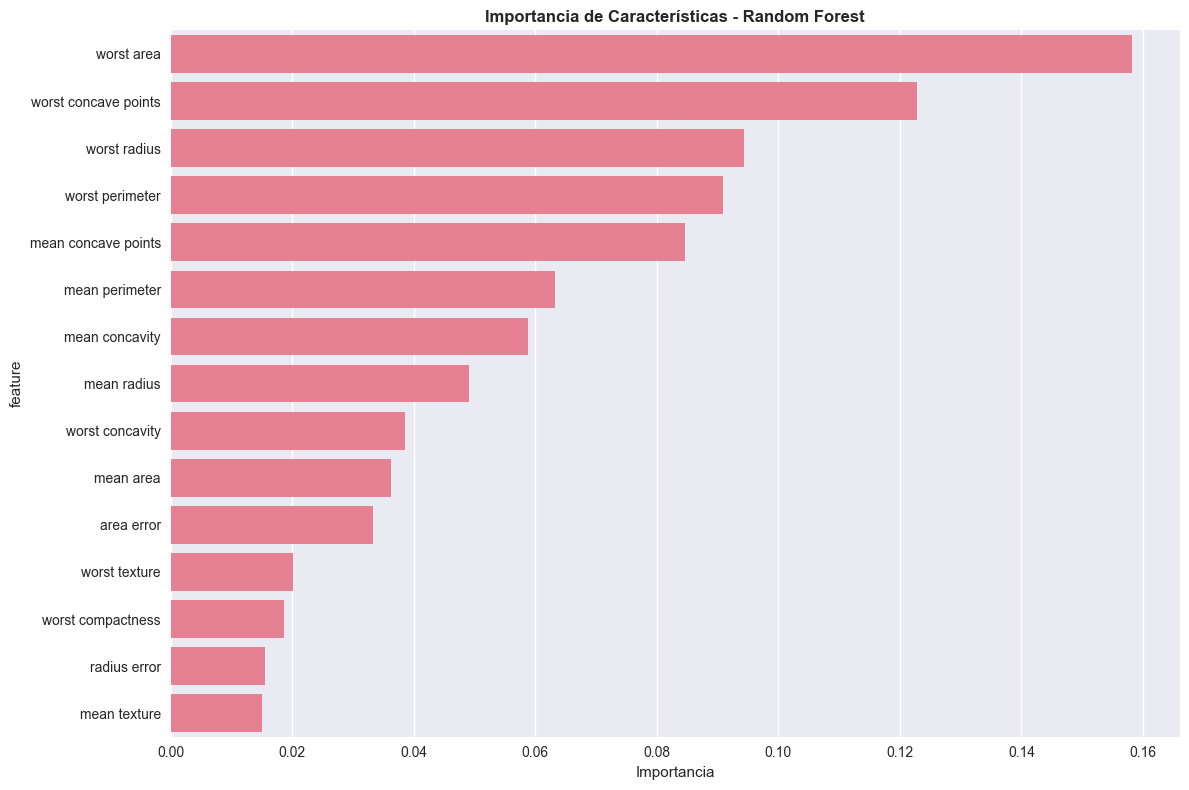

In [26]:
# 13. ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS
# =============================================

print(f"\n🔍 ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS:")

# Para Random Forest
if 'Random Forest' in models_results:
    rf_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': models_results['Random Forest']['model'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🌳 TOP 10 CARACTERÍSTICAS MÁS IMPORTANTES (Random Forest):")
    for i, (_, row) in enumerate(rf_importance.head(10).iterrows()):
        print(f"   {i+1:2d}. {row['feature']:<25}: {row['importance']:.4f}")
    
    # Visualización
    plt.figure(figsize=(12, 8))
    sns.barplot(data=rf_importance.head(15), x='importance', y='feature')
    plt.title('Importancia de Características - Random Forest', fontweight='bold')
    plt.xlabel('Importancia')
    plt.tight_layout()
    plt.show()


In [27]:

# 14. VALIDACIÓN CRUZADA
# ======================

print(f"\n✅ VALIDACIÓN CRUZADA (5-fold):")

cv_results = {}
for model_name, results in models_results.items():
    cv_scores = cross_val_score(results['model'], X_train_final, y_train_final, cv=5)
    cv_results[model_name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    
    print(f"   • {model_name:<20}: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")



✅ VALIDACIÓN CRUZADA (5-fold):
   • SVM                 : 0.9755 (±0.0128)
   • Decision Tree       : 0.9436 (±0.0189)
   • Random Forest       : 0.9681 (±0.0219)
   • Logistic Regression : 0.9812 (±0.0103)
   • KNN                 : 0.9662 (±0.0226)
